In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.boolean_reasoning"

In [2]:
#instead of installing library...
from config import library_path,snapshot_path

AgentNet examples will store and seek thier snapshots at /home/jheuristic/yozhik/agentnet_snapshots/


In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


/home/jheuristic/thenv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [4]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [5]:
import AgentNet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = (not X1) and X2
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yield information
on Y, and 

In [6]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [7]:
from AgentNet.resolver import EpsilonGreedyResolver
from AgentNet.memory import GRUMemoryLayer
from AgentNet.agent import Agent

In [8]:
import lasagne

#only 10 hidden neurons
n_hid=10


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [10]:
#produce interaction sequences of length <= 10
history = agent.get_sessions(env,session_length=10,
                       batch_size=env.batch_size,)

state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


In [11]:

#Let us compile a function that returns all interaction logs
get_history = theano.function([],history+(is_alive_seq,rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights
 
 
 #### Get (prediction,reference) pairs

In [12]:
#get pairs of corresponding [predicted Qvalues, reference Qvalues] to train on

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')

ref_tuples = env.get_reference(qvalues_seq,
                               action_seq,
                               rewards_seq,
                               is_alive_seq,
                               gamma_or_gammas=gamma,)


action_Qvalues, reference_Qvalues,_ = ref_tuples

In [13]:
#prevent gradient updates over reference Qvalues (since they depend on predicted Qvalues)
from AgentNet.utils import consider_constant
reference_Qvalues = consider_constant(reference_Qvalues)

#### Define loss functions

In [14]:
#tensor of elementwise squared errors
squared_error = lasagne.objectives.squared_error(reference_Qvalues,action_Qvalues)

#zero-out ticks after session ended
squared_error = squared_error * is_alive_seq

#compute average of squared error sums per session
session_mse_loss = squared_error.sum(axis = 1).mean()

In [15]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [16]:
loss = session_mse_loss + reg_l2

#### Compute weight updates

In [17]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [18]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [19]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,session_mse_loss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [20]:
from AgentNet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,reference_Qvalues,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, reference_qv_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   hidden_seq=hidden_log,
                   reference_qvalues_seq = reference_qv_log,
                   action_names=env.feature_names,
                  
                  plot_qvalues = with_plots)

session # 0
 X1(qv = 0.0) -> -1.0(ref = -0.942587912083) |  X2(qv = 0.0604337751865) -> 1.0(ref = 1.12796711922) |  X2(qv = 0.134702190757) -> -0.5(ref = -0.339402377605) |  X2(qv = 0.169050127268) -> -0.5(ref = -0.323682427406) |  X2(qv = 0.18559743464) -> -0.5(ref = -0.31589448452) |  X2(qv = 0.193795263767) -> -0.5(ref = -0.311952114105) |  X3(qv = -0.164187282324) -> 1.0(ref = 1.16259622574) |  X2(qv = 0.171153947711) -> -0.5(ref = -0.324161469936) |  Y2(qv = 0.0573995858431) -> -3.0(ref = -2.97727274895) |  X2(qv = 0.0239233523607) -> -0.5(ref = -0.5) |

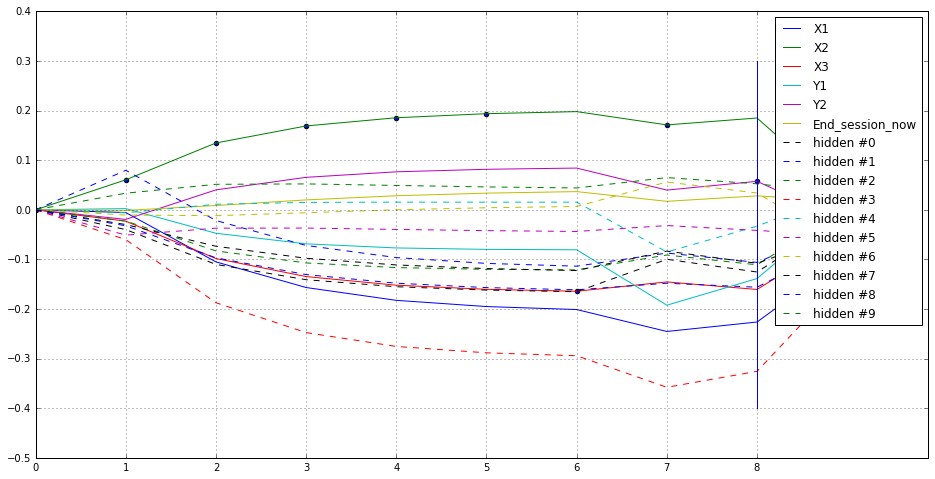

In [21]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [22]:
from AgentNet.utils.persistence import save,load

In [23]:
from AgentNet.display import Metrics
score_log = Metrics()

In [24]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 15.76506, epsilon 0.96275, rewards: ( e-greedy -0.01667, greedy 0.00000) 
rec 15.753 reg 0.012
epoch 200,loss 7.60518, epsilon 0.92696, rewards: ( e-greedy 0.01833, greedy 0.00000) 
rec 7.593 reg 0.012
epoch 300,loss 8.51400, epsilon 0.89257, rewards: ( e-greedy 0.08317, greedy -0.11667) 
rec 8.502 reg 0.012
epoch 400,loss 11.65895, epsilon 0.85954, rewards: ( e-greedy -0.09182, greedy 0.19500) 
rec 11.647 reg 0.012
epoch 500,loss 12.27353, epsilon 0.82779, rewards: ( e-greedy -0.24930, greedy 0.47550) 
rec 12.262 reg 0.012
epoch 600,loss 10.08318, epsilon 0.79730, rewards: ( e-greedy -0.45770, greedy 0.49462) 
rec 10.071 reg 0.012
epoch 700,loss 13.05962, epsilon 0.76799, rewards: ( e-greedy -0.39527, greedy 0.52849) 
rec 13.047 reg 0.012
epoch 800,loss 10.13880, epsilon 0.73984, rewards: ( e-greedy -0.15574, greedy 0.77564) 
rec 10.126 reg 0.013
epoch 900,loss 18.16630, epsilon 0.71279, rewards: ( e-greedy -0.27350, greedy 0.78141) 
rec 18.153 reg 0.013
epoch 1000,loss

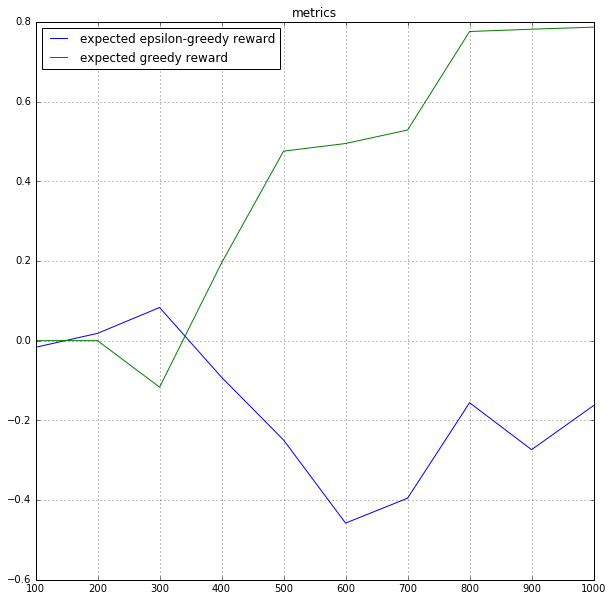

Random session examples
session # 0
 Y1(qv = -0.232261925936) -> -3.0(ref = -2.55095529556) |  End_session_now(qv = 0.119752183557) -> 0.0(ref = 0.271565198898) |  Y1(qv = -0.0592010915279) -> 0.0(ref = 0.0) | 



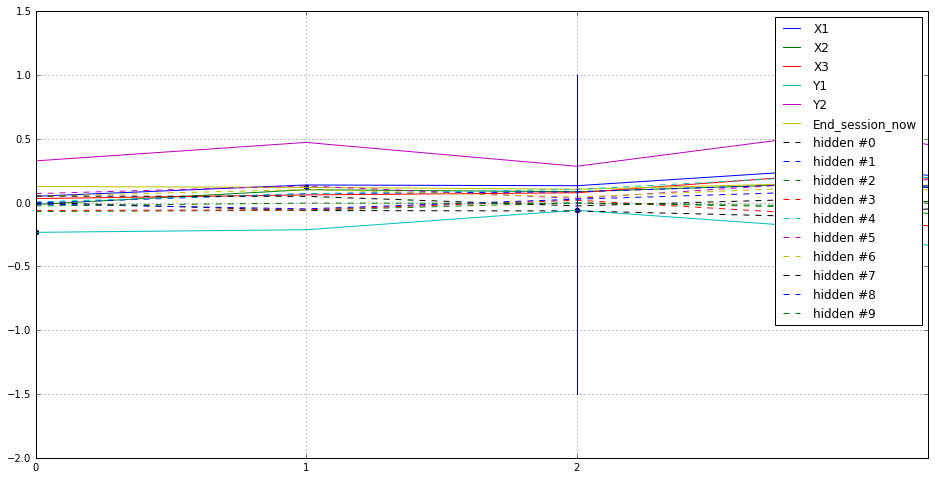

session # 1
 Y1(qv = -0.232261925936) -> -3.0(ref = -2.55095529556) |  X1(qv = 0.139023408294) -> -1.0(ref = -0.533191561699) |  X3(qv = 0.0178913101554) -> -1.0(ref = -0.593964278698) |  X1(qv = -0.024006947875) -> -0.5(ref = -0.113155812025) |  X3(qv = -0.0520178824663) -> -0.5(ref = -0.165049850941) |  X1(qv = -0.0837584286928) -> -0.5(ref = -0.17199113965) |  End_session_now(qv = 0.149962157011) -> 0.0(ref = 0.134160459042) |  Y2(qv = 0.141221538186) -> 0.0(ref = 0.0) | 



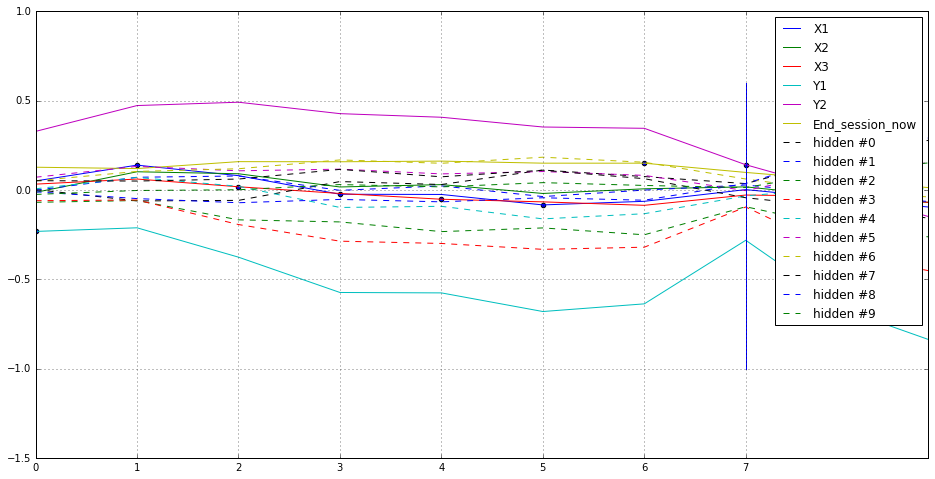

session # 2
 X1(qv = 0.0505104511976) -> -1.0(ref = -0.612398266792) |  X1(qv = 0.0321841947734) -> -0.5(ref = -0.090406358242) |  Y2(qv = 0.431151211262) -> 3.0(ref = 3.03476905823) |  End_session_now(qv = 0.0365989431739) -> 0.0(ref = 0.032616533339) |  End_session_now(qv = 0.034333191812) -> 0.0(ref = 0.0) | 



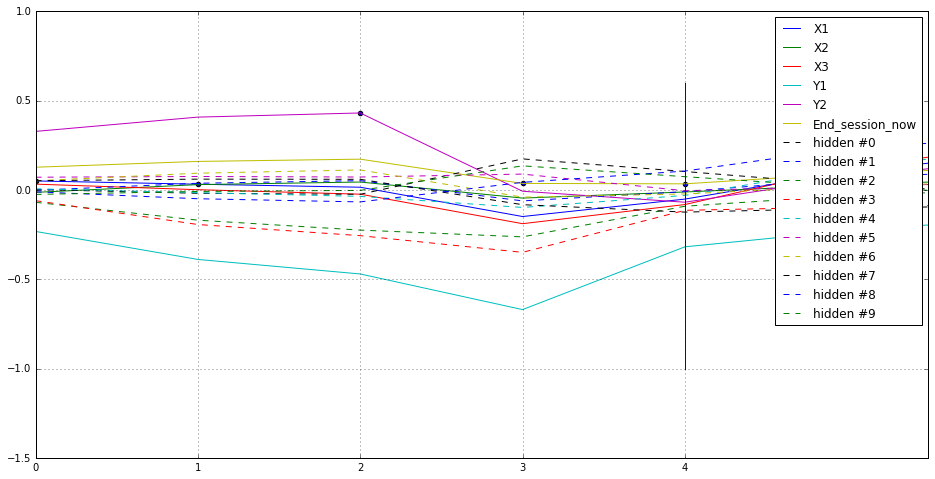

epoch 1100,loss 9.56671, epsilon 0.66183, rewards: ( e-greedy -0.04654, greedy 1.00794) 
rec 9.553 reg 0.014
epoch 1200,loss 10.56688, epsilon 0.63784, rewards: ( e-greedy -0.15855, greedy 0.99048) 
rec 10.553 reg 0.014
epoch 1300,loss 7.63012, epsilon 0.61479, rewards: ( e-greedy -0.14269, greedy 0.97477) 
rec 7.616 reg 0.014
epoch 1400,loss 22.54822, epsilon 0.59265, rewards: ( e-greedy -0.24509, greedy 0.74396) 
rec 22.533 reg 0.015
epoch 1500,loss 8.64917, epsilon 0.57137, rewards: ( e-greedy -0.12058, greedy 0.75289) 
rec 8.634 reg 0.015
epoch 1600,loss 11.73090, epsilon 0.55093, rewards: ( e-greedy -0.07519, greedy 0.76094) 
rec 11.715 reg 0.016
epoch 1700,loss 11.65959, epsilon 0.53129, rewards: ( e-greedy -0.25100, greedy 0.45151) 
rec 11.643 reg 0.017
epoch 1800,loss 10.00336, epsilon 0.51241, rewards: ( e-greedy -0.24257, greedy 0.43969) 
rec 9.986 reg 0.017
epoch 1900,loss 4.24983, epsilon 0.49428, rewards: ( e-greedy 0.01502, greedy 0.69572) 
rec 4.232 reg 0.018
epoch 2000,

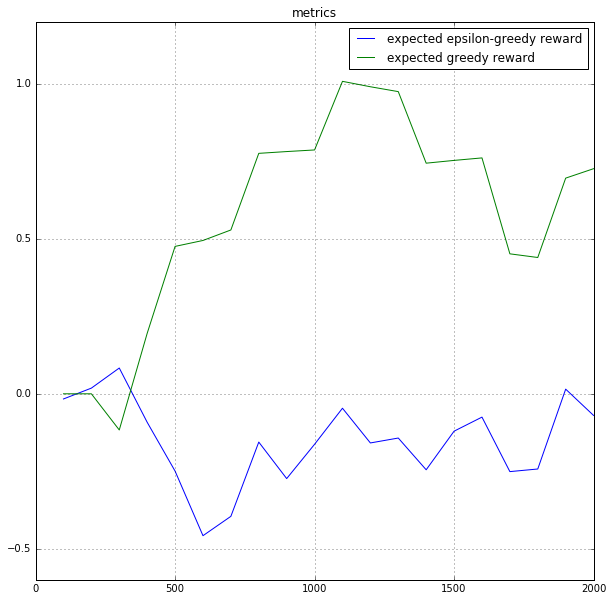

Random session examples
session # 0
 Y2(qv = 0.789338469505) -> 3.0(ref = 3.0040102005) |  End_session_now(qv = 0.00422134995461) -> 0.0(ref = 0.00719956727698) |  X1(qv = -0.0151502117515) -> 0.0(ref = 0.0) | 



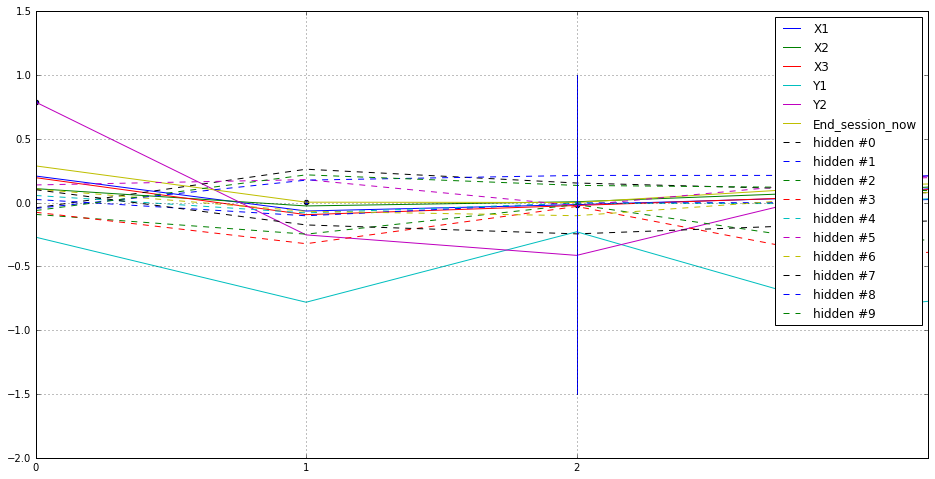

session # 1
 Y2(qv = 0.789338469505) -> 3.0(ref = 3.0040102005) |  Y2(qv = -0.252237170935) -> -0.5(ref = -0.675790071487) |  X2(qv = -0.185042202473) -> -1.0(ref = -1.05728721619) |  X3(qv = -0.18836183846) -> -1.0(ref = -0.973369956017) |  End_session_now(qv = 0.0280316025019) -> 0.0(ref = 0.0039525963366) |  Y2(qv = -0.454465478659) -> 0.0(ref = 0.0) | 



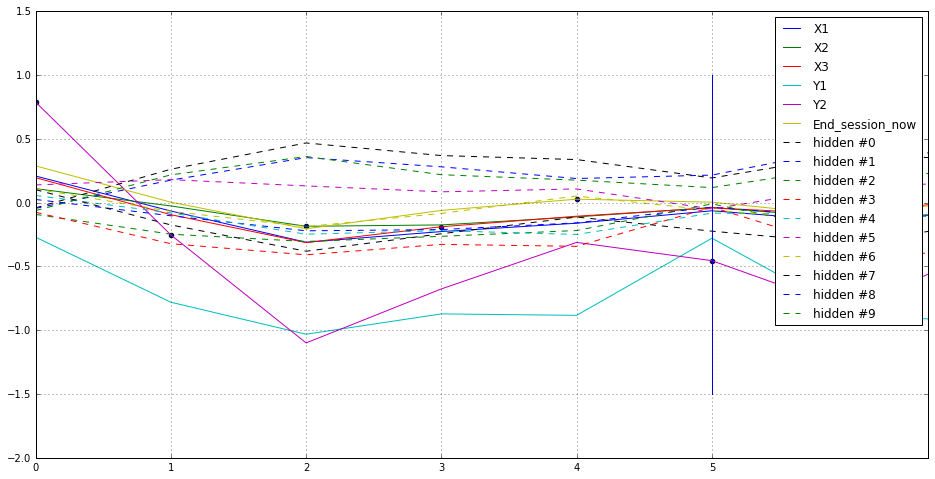

session # 2
 Y2(qv = 0.789338469505) -> 3.0(ref = 3.0040102005) |  End_session_now(qv = 0.00422134995461) -> 0.0(ref = 0.00719954632223) |  X2(qv = 0.00757846981287) -> 0.0(ref = 0.0) | 



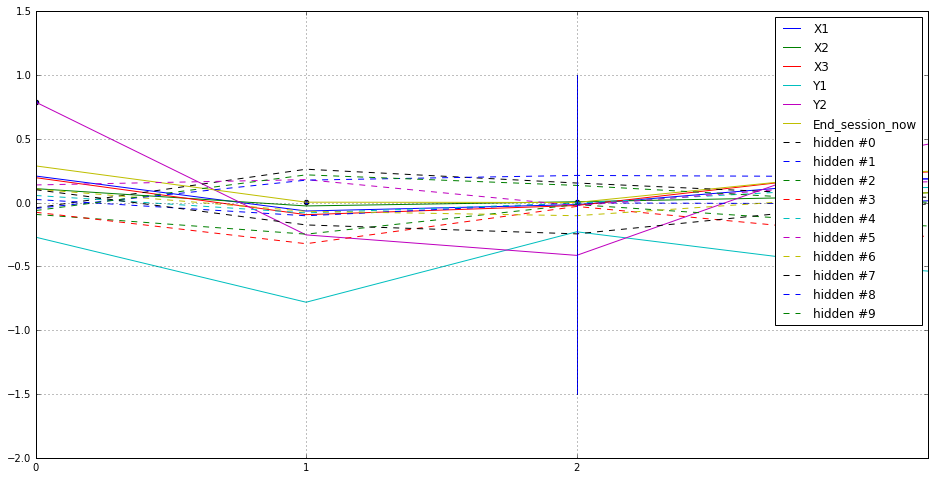

epoch 2100,loss 9.78695, epsilon 0.46012, rewards: ( e-greedy -0.11283, greedy 0.75354) 
rec 9.768 reg 0.019
epoch 2200,loss 5.89296, epsilon 0.44404, rewards: ( e-greedy 0.13178, greedy 0.97818) 
rec 5.873 reg 0.019
epoch 2300,loss 8.94651, epsilon 0.42859, rewards: ( e-greedy 0.36860, greedy 1.18036) 
rec 8.926 reg 0.020
epoch 2400,loss 5.97810, epsilon 0.41375, rewards: ( e-greedy 0.36508, greedy 1.36233) 
rec 5.957 reg 0.021
epoch 2500,loss 2.89673, epsilon 0.39949, rewards: ( e-greedy 0.52857, greedy 1.52609) 
rec 2.875 reg 0.021
epoch 2600,loss 9.48142, epsilon 0.38578, rewards: ( e-greedy 0.57571, greedy 1.47349) 
rec 9.460 reg 0.022
epoch 2700,loss 7.28821, epsilon 0.37262, rewards: ( e-greedy 0.58481, greedy 1.42614) 
rec 7.266 reg 0.022
epoch 2800,loss 6.75929, epsilon 0.35997, rewards: ( e-greedy 0.49299, greedy 1.38352) 
rec 6.737 reg 0.022
epoch 2900,loss 8.04819, epsilon 0.34781, rewards: ( e-greedy 0.49369, greedy 1.29517) 
rec 8.025 reg 0.023
epoch 3000,loss 1.73379, ep

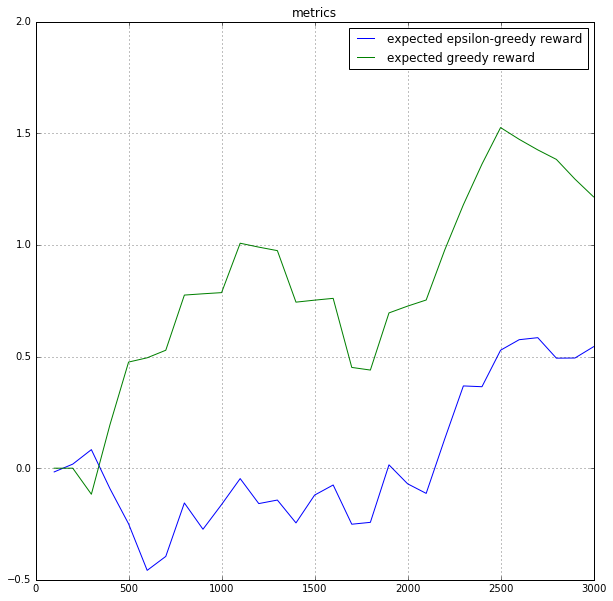

Random session examples
session # 0
 X1(qv = 0.364360064268) -> 1.0(ref = 2.102612257) |  X2(qv = 0.329860746861) -> 1.0(ref = 1.61933529377) |  Y2(qv = 0.651931881905) -> 3.0(ref = 2.82879734039) |  X3(qv = -0.356853544712) -> -1.0(ref = -1.09011137486) |  End_session_now(qv = -0.0948541164398) -> 0.0(ref = -0.0797014012933) |  X2(qv = -0.0838962122798) -> 0.0(ref = 0.0) | 



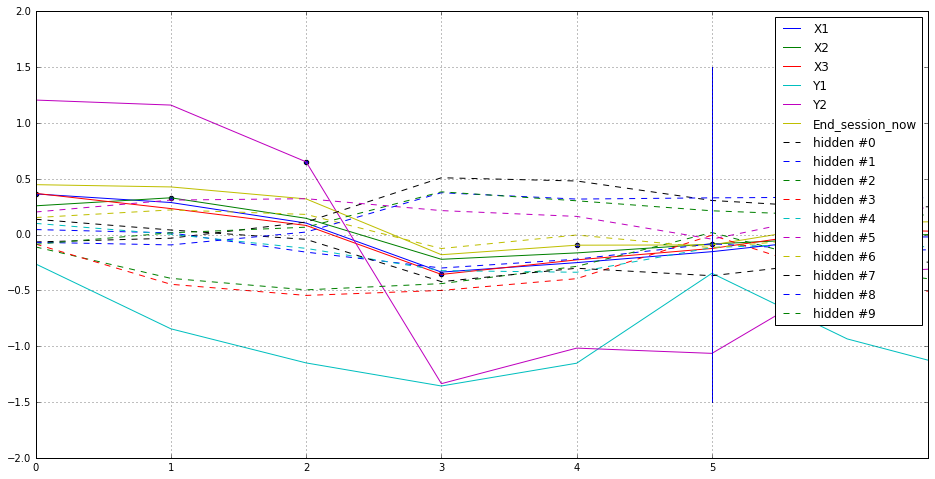

session # 1
 Y2(qv = 1.20559704304) -> 3.0(ref = 3.00689673424) |  X1(qv = -0.049884788692) -> -1.0(ref = -0.892425358295) |  X3(qv = -0.0058561861515) -> -1.0(ref = -0.789179086685) |  Y2(qv = 0.221916764975) -> -0.5(ref = -0.676871061325) |  End_session_now(qv = -0.186180055141) -> 0.0(ref = -0.131790339947) |  X2(qv = -0.138726681471) -> 0.0(ref = 0.0) | 



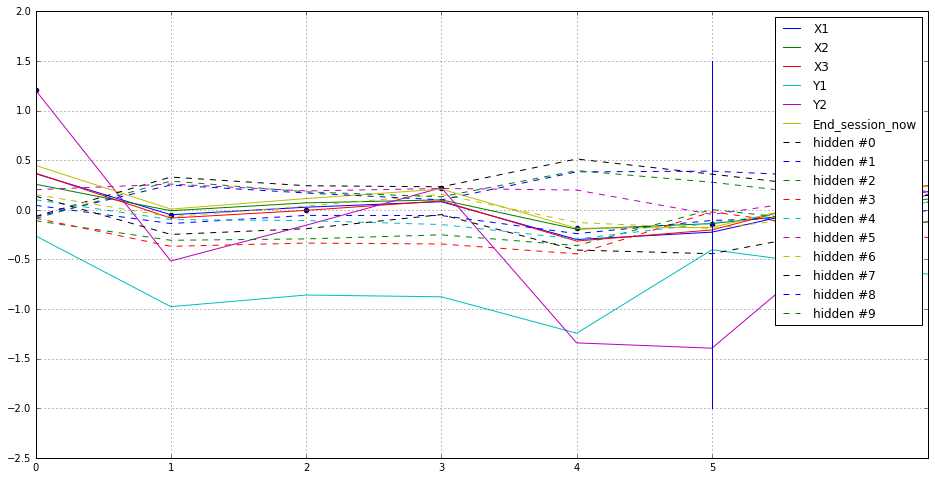

session # 2
 X2(qv = 0.257954806089) -> -1.0(ref = 0.557867646217) |  Y2(qv = 1.63986074924) -> 3.0(ref = 3.02645945549) |  Y2(qv = -0.439954966307) -> -0.5(ref = -0.783172309399) |  X2(qv = -0.298076122999) -> -0.5(ref = -0.642310142517) |  X1(qv = -0.301714748144) -> 1.0(ref = 0.902521133423) |  Y1(qv = -1.29023814201) -> -3.0(ref = -2.98522233963) |  X2(qv = 0.0155554190278) -> -0.5(ref = -0.369357645512) |  End_session_now(qv = 0.137518271804) -> 0.0(ref = 0.104103751481) |  End_session_now(qv = 0.109582901001) -> 0.0(ref = 0.0) | 



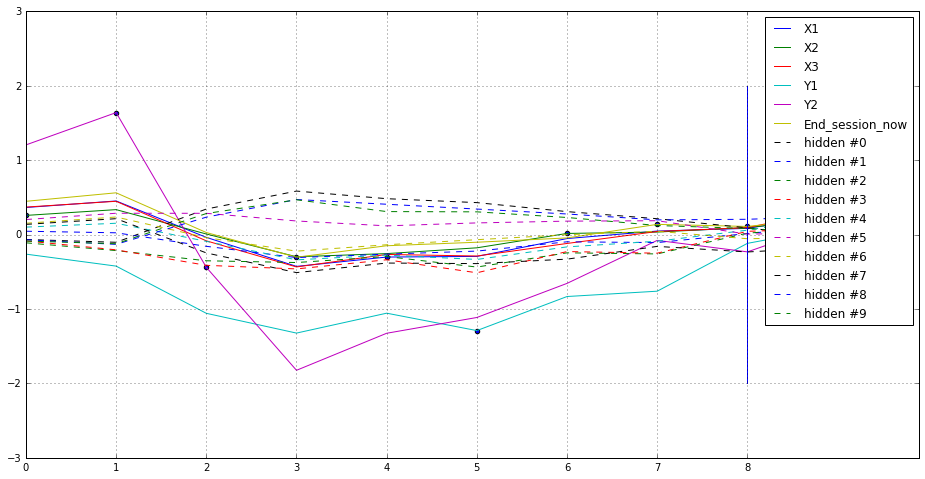

epoch 3100,loss 8.85759, epsilon 0.32492, rewards: ( e-greedy 0.62323, greedy 1.17742) 
rec 8.834 reg 0.024
epoch 3200,loss 8.16841, epsilon 0.31414, rewards: ( e-greedy 0.66090, greedy 1.15968) 
rec 8.145 reg 0.024
epoch 3300,loss 10.19142, epsilon 0.30378, rewards: ( e-greedy 0.62815, greedy 1.14371) 
rec 10.168 reg 0.024
epoch 3400,loss 18.50491, epsilon 0.29383, rewards: ( e-greedy 0.46533, greedy 0.86267) 
rec 18.481 reg 0.024
epoch 3500,loss 3.57687, epsilon 0.28427, rewards: ( e-greedy 0.65213, greedy 1.07641) 
rec 3.552 reg 0.024
epoch 3600,loss 7.33865, epsilon 0.27508, rewards: ( e-greedy 0.65359, greedy 1.06877) 
rec 7.314 reg 0.024
epoch 3700,loss 4.38040, epsilon 0.26626, rewards: ( e-greedy 0.95489, greedy 1.26189) 
rec 4.356 reg 0.024
epoch 3800,loss 2.59991, epsilon 0.25778, rewards: ( e-greedy 1.10940, greedy 1.43570) 
rec 2.575 reg 0.025
epoch 3900,loss 13.61144, epsilon 0.24963, rewards: ( e-greedy 1.23180, greedy 1.39213) 
rec 13.587 reg 0.025
epoch 4000,loss 14.720

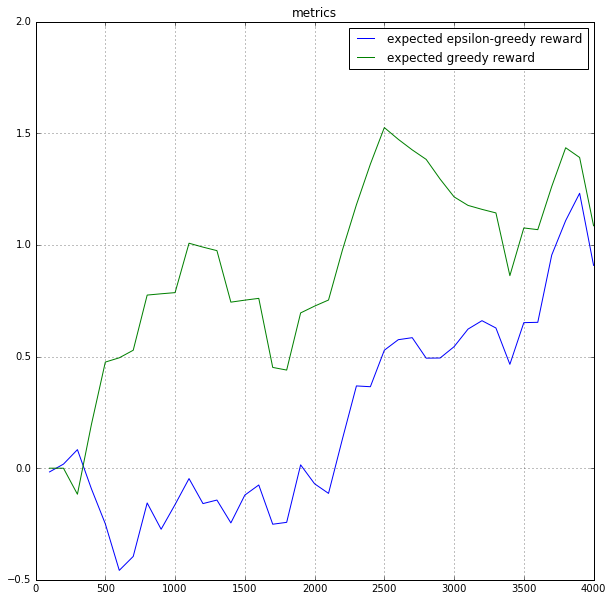

Random session examples
session # 0
 Y2(qv = 1.36458384991) -> 3.0(ref = 3.00081372261) |  X2(qv = 0.000856652855873) -> 1.0(ref = 1.00128364563) |  End_session_now(qv = 0.00135114789009) -> 0.0(ref = -0.0438238978386) |  End_session_now(qv = -0.048123806715) -> 0.0(ref = 0.0) | 



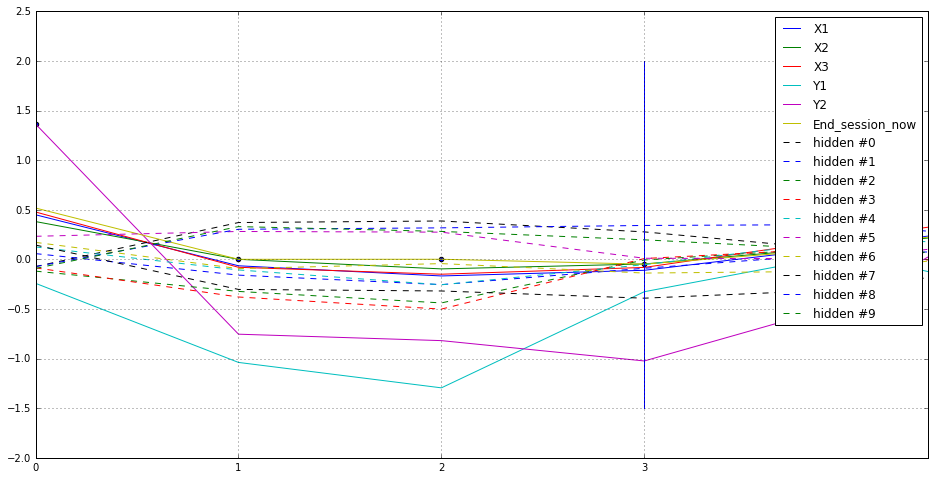

session # 1
 Y2(qv = 1.36458384991) -> 3.0(ref = 3.00081372261) |  X2(qv = 0.000856652855873) -> -1.0(ref = -0.878586530685) |  X3(qv = 0.0492159724236) -> -1.0(ref = -0.782688260078) |  Y2(qv = 0.146732479334) -> -0.5(ref = -0.678034305573) |  End_session_now(qv = -0.194056540728) -> 0.0(ref = -0.107409760356) |  X2(qv = -0.113062903285) -> 0.0(ref = 0.0) | 



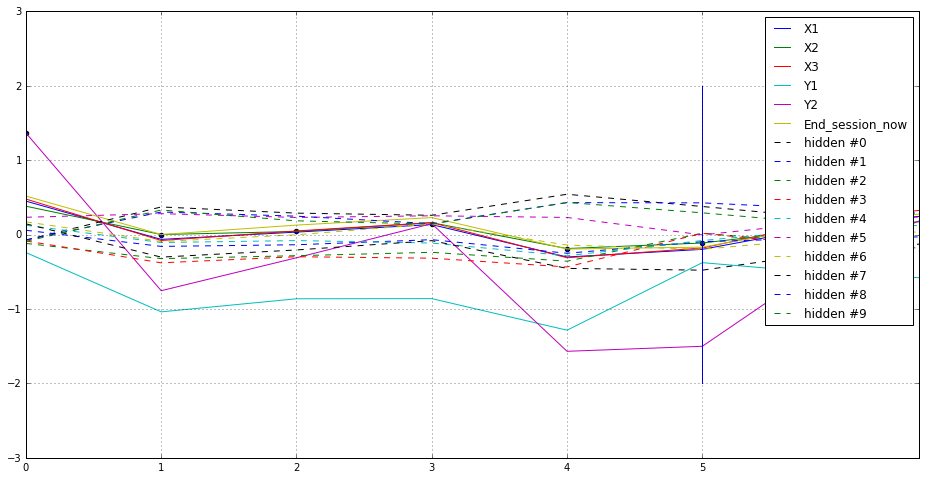

session # 2
 Y2(qv = 1.36458384991) -> 3.0(ref = 3.00081372261) |  X2(qv = 0.000856652855873) -> -1.0(ref = -0.878586530685) |  End_session_now(qv = 0.127803653479) -> 0.0(ref = 0.0870389193296) |  Y1(qv = -0.115467324853) -> 0.0(ref = 0.0) | 



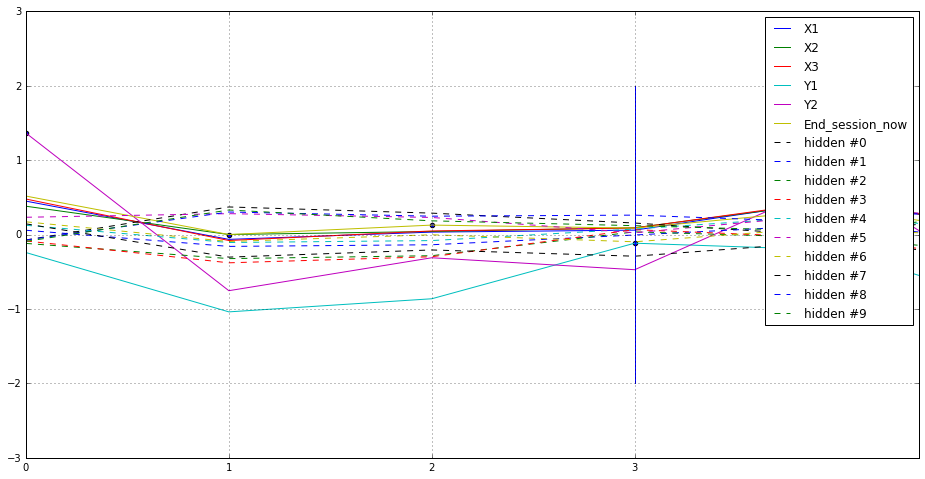

epoch 4100,loss 3.50679, epsilon 0.23428, rewards: ( e-greedy 0.91776, greedy 1.17763) 
rec 3.481 reg 0.025
epoch 4200,loss 2.61559, epsilon 0.22706, rewards: ( e-greedy 1.12598, greedy 1.35986) 
rec 2.590 reg 0.026
epoch 4300,loss 8.16817, epsilon 0.22011, rewards: ( e-greedy 1.09672, greedy 1.29054) 
rec 8.142 reg 0.026
epoch 4400,loss 9.25482, epsilon 0.21344, rewards: ( e-greedy 1.02038, greedy 1.22816) 
rec 9.228 reg 0.027
epoch 4500,loss 2.32886, epsilon 0.20703, rewards: ( e-greedy 1.15167, greedy 1.40534) 
rec 2.302 reg 0.027
epoch 4600,loss 2.43302, epsilon 0.20088, rewards: ( e-greedy 1.33651, greedy 1.56481) 
rec 2.406 reg 0.027
epoch 4700,loss 4.02162, epsilon 0.19496, rewards: ( e-greedy 1.60285, greedy 1.74166) 
rec 3.995 reg 0.027
epoch 4800,loss 3.36382, epsilon 0.18928, rewards: ( e-greedy 1.62590, greedy 1.90083) 
rec 3.336 reg 0.027
epoch 4900,loss 3.31393, epsilon 0.18382, rewards: ( e-greedy 1.71331, greedy 1.96074) 
rec 3.286 reg 0.028
epoch 5000,loss 3.90152, eps

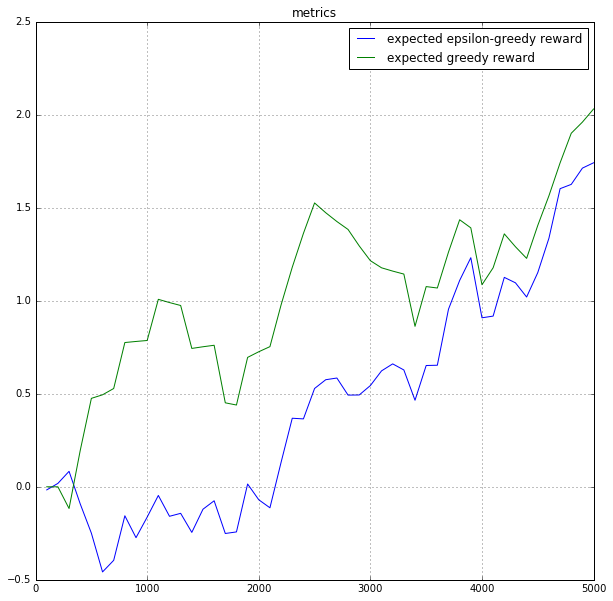

Random session examples
session # 0
 Y2(qv = 1.54049038887) -> 3.0(ref = 3.08228492737) |  X1(qv = 0.0866156667471) -> -1.0(ref = -0.953891992569) |  End_session_now(qv = 0.0485347509384) -> 0.0(ref = 0.0436227098107) |  End_session_now(qv = 0.0459186434746) -> 0.0(ref = 0.0) | 



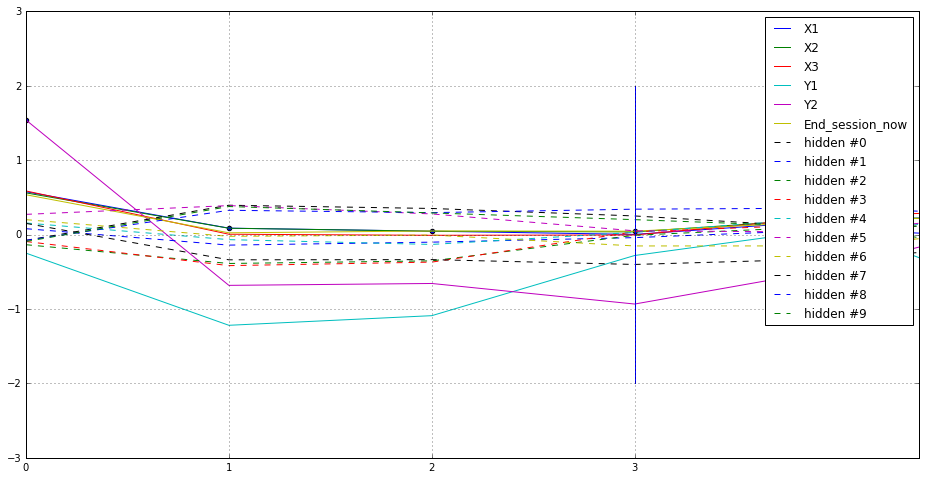

session # 1
 Y2(qv = 1.54049038887) -> 3.0(ref = 3.08228492737) |  X1(qv = 0.0866156667471) -> 1.0(ref = 0.946310639381) |  End_session_now(qv = -0.0565151274204) -> 0.0(ref = -0.0635524094105) |  End_session_now(qv = -0.0668972730637) -> 0.0(ref = 0.0) | 



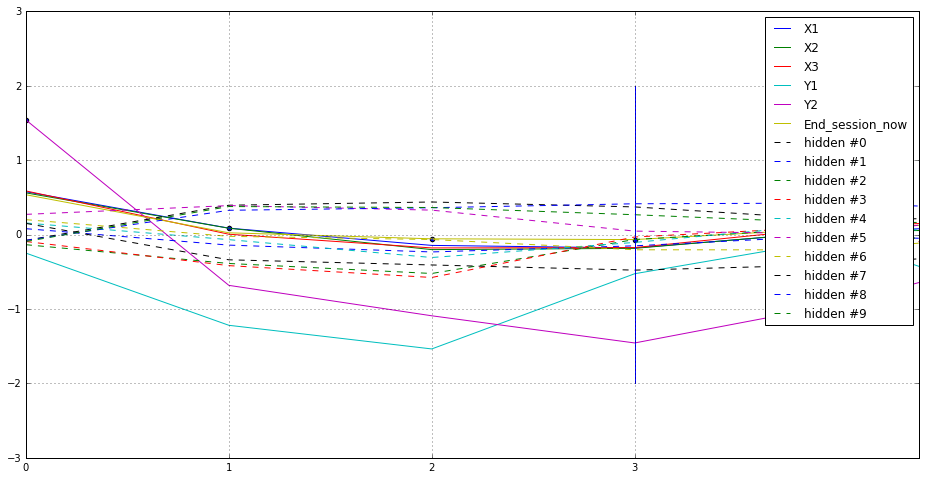

session # 2
 Y2(qv = 1.54049038887) -> 3.0(ref = 3.08228492737) |  X1(qv = 0.0866156667471) -> 1.0(ref = 0.946310639381) |  End_session_now(qv = -0.0565150976181) -> 0.0(ref = -0.0635524094105) |  End_session_now(qv = -0.0668972730637) -> 0.0(ref = 0.0) | 



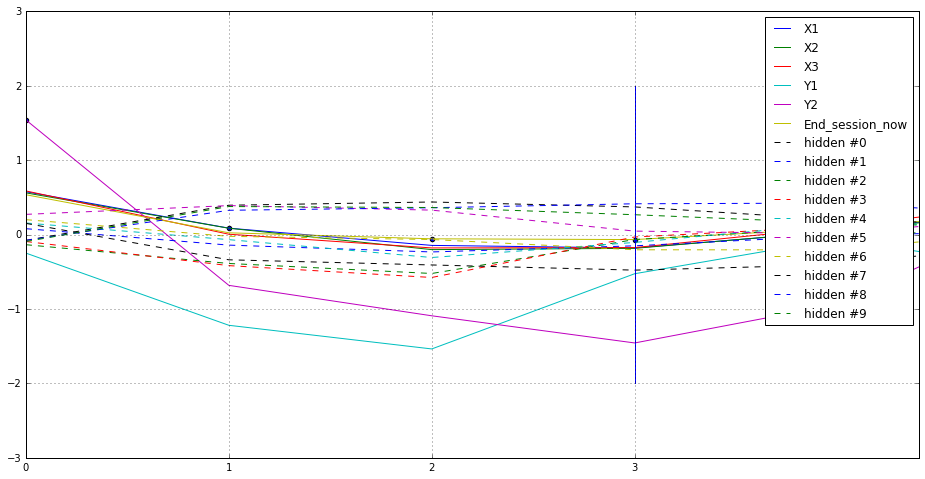

epoch 5100,loss 4.67498, epsilon 0.17353, rewards: ( e-greedy 1.73445, greedy 2.16154) 
rec 4.646 reg 0.029
epoch 5200,loss 3.71604, epsilon 0.16868, rewards: ( e-greedy 1.86100, greedy 2.21205) 
rec 3.687 reg 0.029
epoch 5300,loss 18.78361, epsilon 0.16403, rewards: ( e-greedy 1.77490, greedy 1.99084) 
rec 18.754 reg 0.030
epoch 5400,loss 8.18483, epsilon 0.15956, rewards: ( e-greedy 1.74741, greedy 1.92509) 
rec 8.155 reg 0.030
epoch 5500,loss 3.73534, epsilon 0.15526, rewards: ( e-greedy 1.72267, greedy 1.96592) 
rec 3.705 reg 0.030
epoch 5600,loss 7.51019, epsilon 0.15114, rewards: ( e-greedy 1.75041, greedy 1.96933) 
rec 7.480 reg 0.030
epoch 5700,loss 7.89774, epsilon 0.14717, rewards: ( e-greedy 1.65870, greedy 1.88906) 
rec 7.867 reg 0.031
epoch 5800,loss 3.18304, epsilon 0.14336, rewards: ( e-greedy 1.82616, greedy 2.03349) 
rec 3.152 reg 0.031
epoch 5900,loss 3.32060, epsilon 0.13970, rewards: ( e-greedy 1.94355, greedy 2.16347) 
rec 3.289 reg 0.031
epoch 6000,loss 7.83627, e

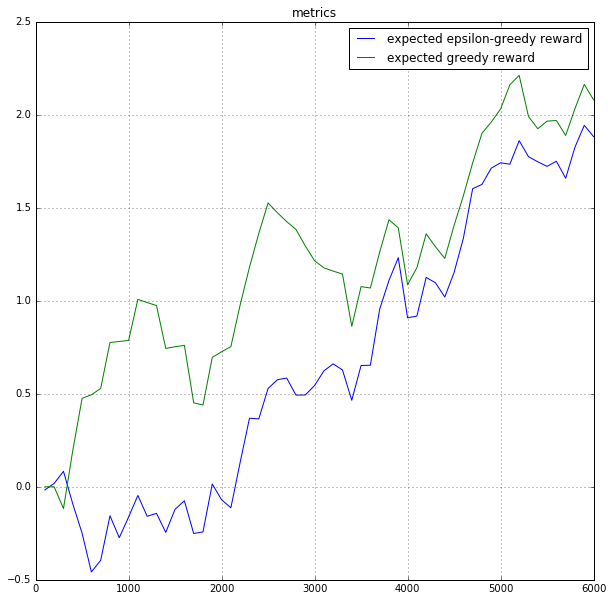

Random session examples
session # 0
 Y2(qv = 1.66447782516) -> 3.0(ref = 3.17634630203) |  X1(qv = 0.185627818108) -> 1.0(ref = 0.949886798859) |  End_session_now(qv = -0.052750736475) -> 0.0(ref = -0.0514392592013) |  End_session_now(qv = -0.0541465878487) -> 0.0(ref = 0.0) | 



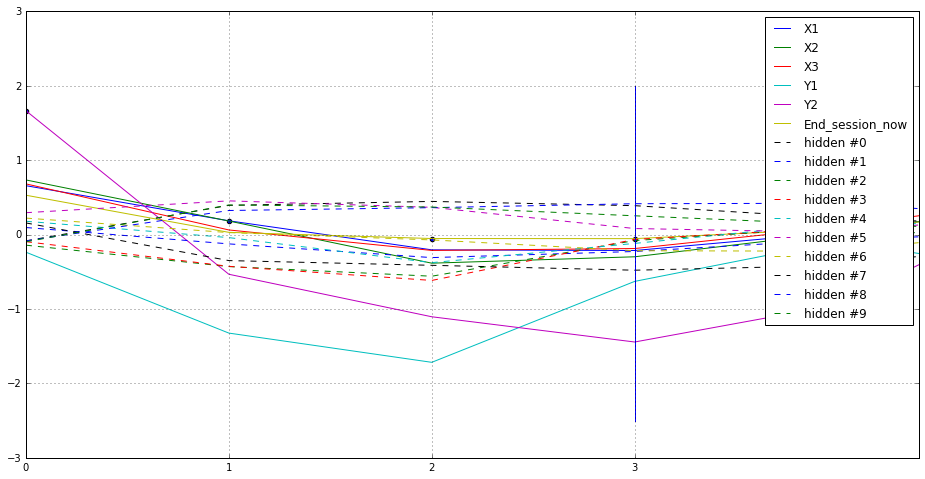

session # 1
 Y2(qv = 1.66447782516) -> -3.0(ref = -2.31891727448) |  X2(qv = 0.716929256916) -> 1.0(ref = 1.1136418581) |  End_session_now(qv = 0.11962300539) -> 0.0(ref = 0.0690465345979) |  End_session_now(qv = 0.0726805627346) -> 0.0(ref = 0.0) | 



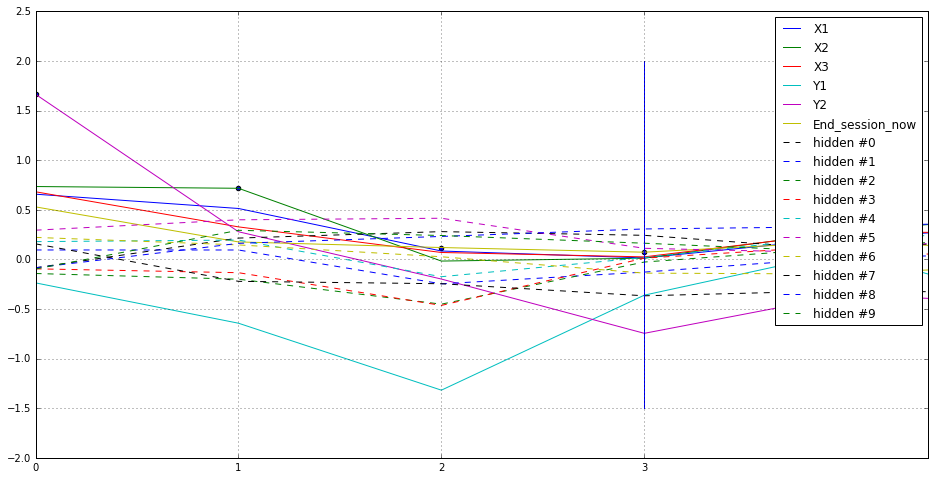

session # 2
 Y2(qv = 1.66447770596) -> -3.0(ref = -2.31891727448) |  X2(qv = 0.716929256916) -> 1.0(ref = 1.1136418581) |  End_session_now(qv = 0.119623020291) -> 0.0(ref = 0.0690465644002) |  End_session_now(qv = 0.0726805925369) -> 0.0(ref = 0.0) | 



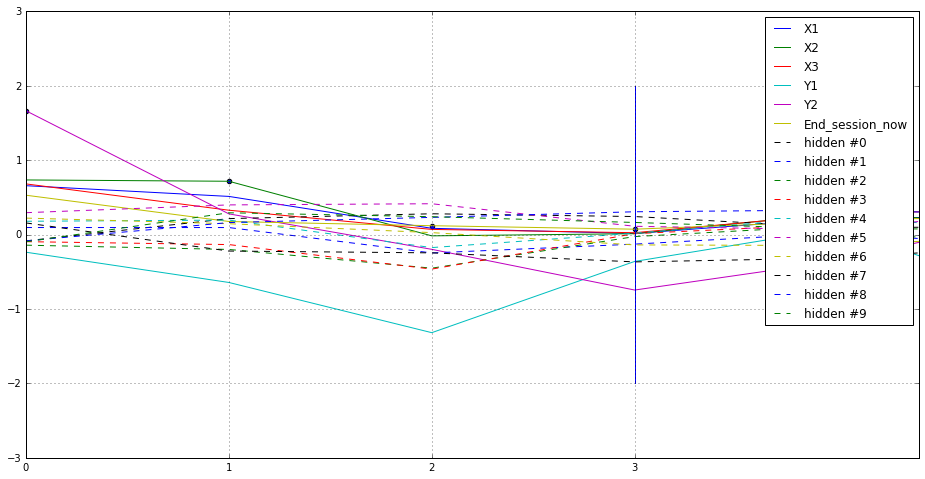

epoch 6100,loss 2.95093, epsilon 0.13280, rewards: ( e-greedy 2.09427, greedy 2.27241) 
rec 2.920 reg 0.031
epoch 6200,loss 8.18097, epsilon 0.12956, rewards: ( e-greedy 1.91818, greedy 2.17850) 
rec 8.149 reg 0.032
epoch 6300,loss 3.38733, epsilon 0.12644, rewards: ( e-greedy 2.02636, greedy 2.36065) 
rec 3.356 reg 0.032
epoch 6400,loss 11.71692, epsilon 0.12344, rewards: ( e-greedy 1.85706, greedy 2.12459) 
rec 11.685 reg 0.032
epoch 6500,loss 2.70458, epsilon 0.12056, rewards: ( e-greedy 2.07135, greedy 2.31213) 
rec 2.672 reg 0.033
epoch 6600,loss 3.66244, epsilon 0.11779, rewards: ( e-greedy 2.19755, greedy 2.31425) 
rec 3.630 reg 0.033
epoch 6700,loss 6.98605, epsilon 0.11513, rewards: ( e-greedy 2.17779, greedy 2.28282) 
rec 6.953 reg 0.033
epoch 6800,loss 7.86002, epsilon 0.11258, rewards: ( e-greedy 1.96002, greedy 2.17121) 
rec 7.827 reg 0.033
epoch 6900,loss 11.73014, epsilon 0.11013, rewards: ( e-greedy 1.69735, greedy 1.88742) 
rec 11.697 reg 0.033
epoch 7000,loss 7.65358,

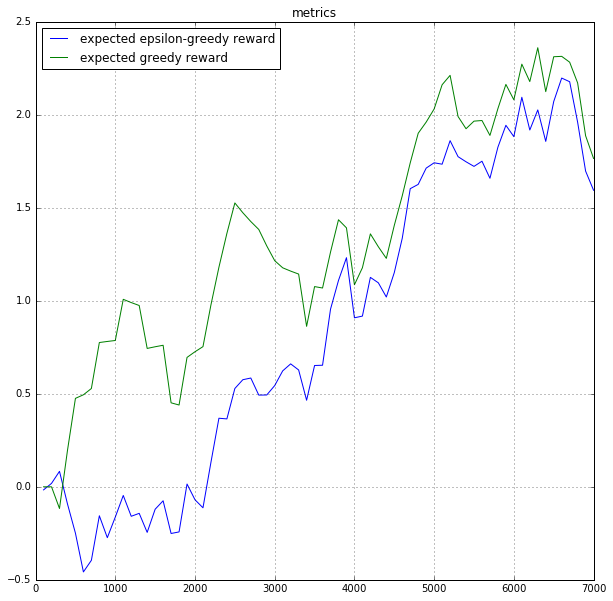

Random session examples
session # 0
 Y2(qv = 1.81596517563) -> 3.0(ref = 3.25485897064) |  X1(qv = 0.268272578716) -> 1.0(ref = 0.962896168232) |  End_session_now(qv = -0.0390566587448) -> 0.0(ref = -0.0293653924018) |  End_session_now(qv = -0.0309109389782) -> 0.0(ref = 0.0) | 



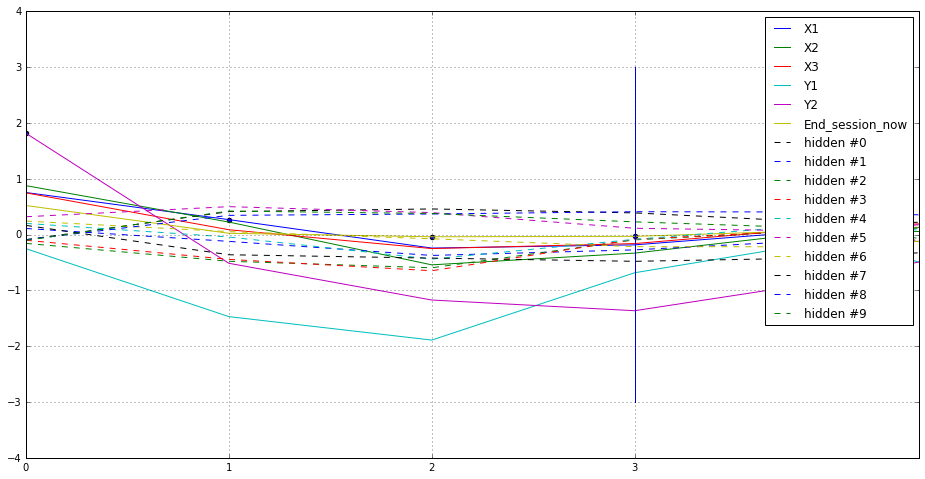

session # 1
 Y2(qv = 1.81596517563) -> -3.0(ref = -2.13911747932) |  X2(qv = 0.906192064285) -> 1.0(ref = 1.0971173048) |  End_session_now(qv = 0.102228760719) -> 0.0(ref = 0.0621100440621) |  End_session_now(qv = 0.0653789937496) -> 0.0(ref = 0.0) | 



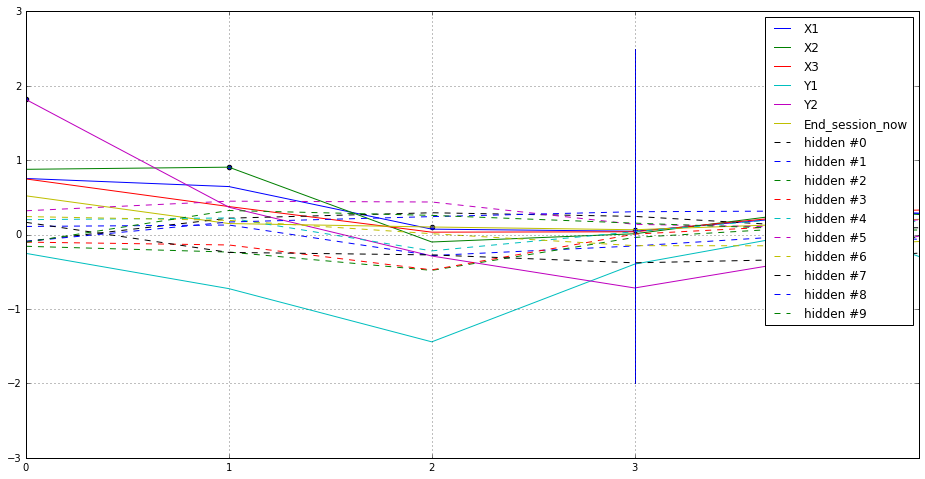

session # 2
 Y2(qv = 1.81596529484) -> 3.0(ref = 3.25485897064) |  X1(qv = 0.268272578716) -> 1.0(ref = 0.962896227837) |  End_session_now(qv = -0.0390566289425) -> 0.0(ref = -0.0293653924018) |  End_session_now(qv = -0.0309109389782) -> 0.0(ref = 0.0) | 



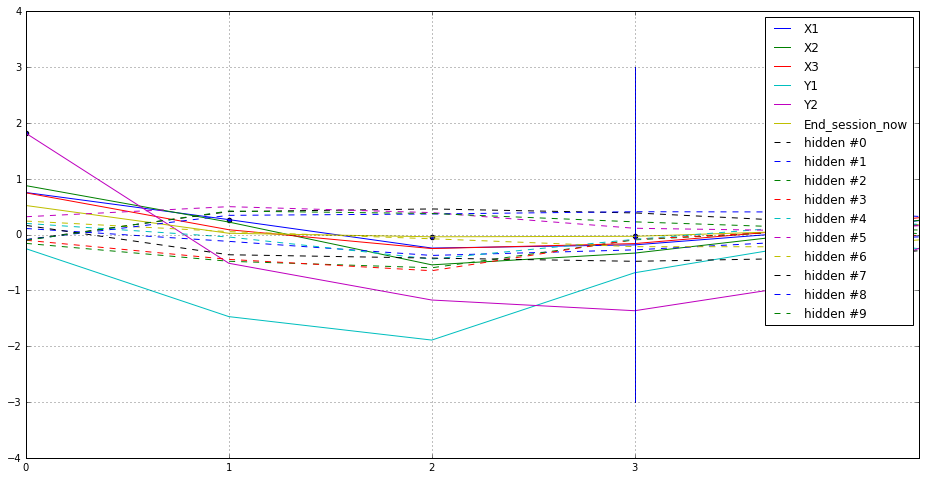

epoch 7100,loss 3.35787, epsilon 0.10550, rewards: ( e-greedy 1.63485, greedy 1.85548) 
rec 3.324 reg 0.033
epoch 7200,loss 2.51757, epsilon 0.10333, rewards: ( e-greedy 1.87137, greedy 2.06993) 
rec 2.484 reg 0.034
epoch 7300,loss 2.85317, epsilon 0.10124, rewards: ( e-greedy 2.01756, greedy 2.19627) 
rec 2.819 reg 0.034
epoch 7400,loss 11.17447, epsilon 0.09923, rewards: ( e-greedy 1.81581, greedy 1.97664) 
rec 11.140 reg 0.034
epoch 7500,loss 7.43732, epsilon 0.09730, rewards: ( e-greedy 1.76756, greedy 1.97898) 
rec 7.403 reg 0.034
epoch 7600,loss 7.67350, epsilon 0.09544, rewards: ( e-greedy 1.72414, greedy 1.91441) 
rec 7.639 reg 0.034
epoch 7700,loss 2.59786, epsilon 0.09366, rewards: ( e-greedy 1.81839, greedy 2.05631) 
rec 2.563 reg 0.035
epoch 7800,loss 11.25161, epsilon 0.09195, rewards: ( e-greedy 1.60322, greedy 1.85068) 
rec 11.217 reg 0.034
epoch 7900,loss 2.56166, epsilon 0.09030, rewards: ( e-greedy 1.77623, greedy 1.99894) 
rec 2.527 reg 0.034
epoch 8000,loss 2.51692,

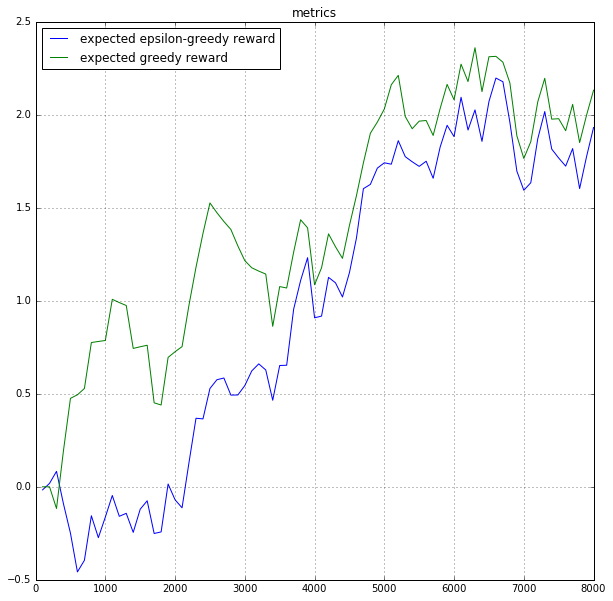

Random session examples
session # 0
 Y2(qv = 1.94022870064) -> 3.0(ref = 3.22394990921) |  X1(qv = 0.235736787319) -> 1.0(ref = 0.978327214718) |  End_session_now(qv = -0.0228134393692) -> 0.0(ref = -0.0129638193175) |  End_session_now(qv = -0.0136461257935) -> 0.0(ref = 0.0) | 



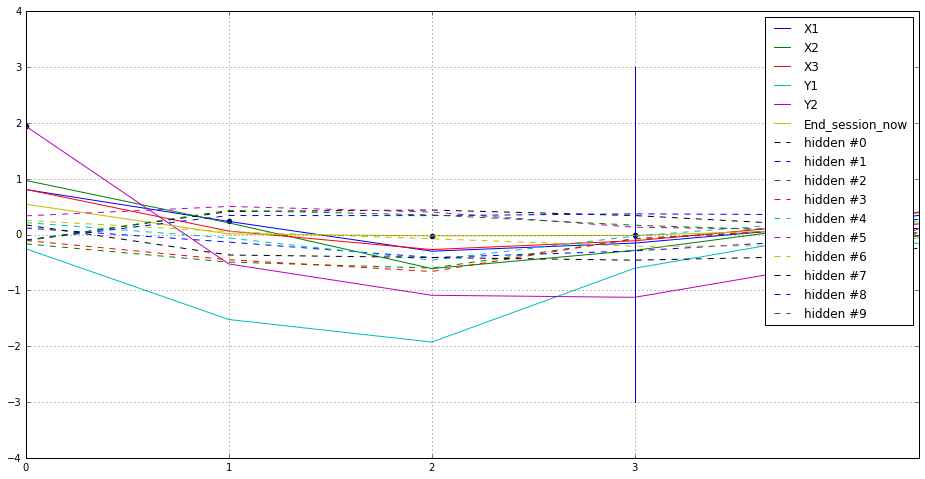

session # 1
 End_session_now(qv = 0.543920218945) -> 0.0(ref = 1.0059697628) |  Y2(qv = 1.05891561508) -> 0.0(ref = 0.0) | 



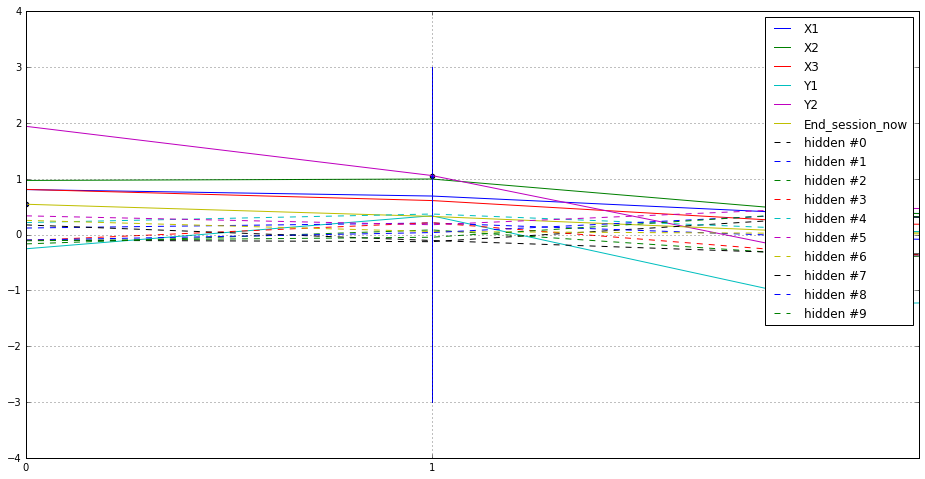

session # 2
 Y2(qv = 1.94022870064) -> 3.0(ref = 3.22394990921) |  X1(qv = 0.235736787319) -> -1.0(ref = -0.946438789368) |  X3(qv = -0.0203045606613) -> 1.0(ref = 1.0710105896) |  End_session_now(qv = 0.0747480392456) -> 0.0(ref = 0.0415608473122) |  End_session_now(qv = 0.0437482595444) -> 0.0(ref = 0.0) | 



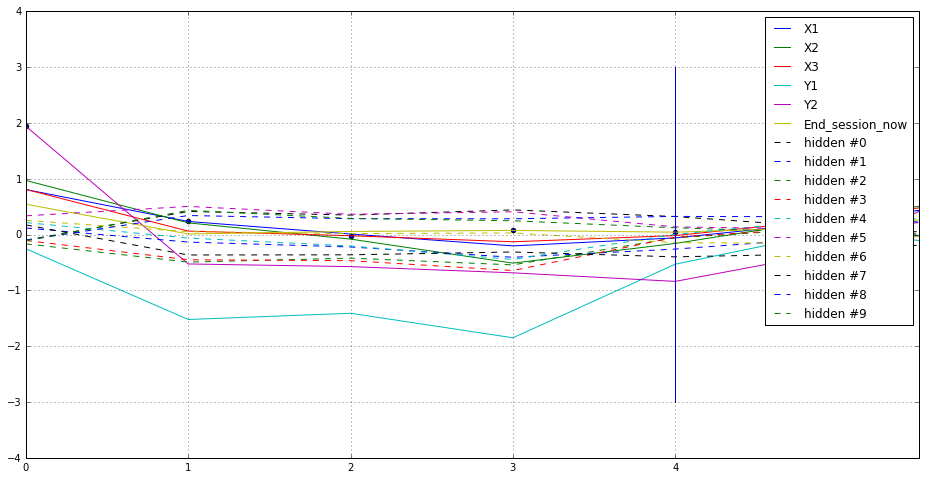

epoch 8100,loss 4.47101, epsilon 0.08721, rewards: ( e-greedy 1.90541, greedy 2.25248) 
rec 4.436 reg 0.035
epoch 8200,loss 2.55229, epsilon 0.08575, rewards: ( e-greedy 2.04820, greedy 2.36056) 
rec 2.518 reg 0.035
epoch 8300,loss 6.75026, epsilon 0.08435, rewards: ( e-greedy 2.04338, greedy 2.32451) 
rec 6.716 reg 0.035
epoch 8400,loss 7.12150, epsilon 0.08300, rewards: ( e-greedy 2.03905, greedy 2.29205) 
rec 7.087 reg 0.035
epoch 8500,loss 2.11039, epsilon 0.08170, rewards: ( e-greedy 2.00181, greedy 2.19618) 
rec 2.076 reg 0.035
epoch 8600,loss 6.61342, epsilon 0.08046, rewards: ( e-greedy 1.95163, greedy 2.17656) 
rec 6.579 reg 0.035
epoch 8700,loss 11.05599, epsilon 0.07927, rewards: ( e-greedy 1.75646, greedy 1.95891) 
rec 11.022 reg 0.034
epoch 8800,loss 2.21581, epsilon 0.07812, rewards: ( e-greedy 1.98082, greedy 2.16302) 
rec 2.181 reg 0.035
epoch 8900,loss 6.70423, epsilon 0.07702, rewards: ( e-greedy 1.98274, greedy 2.14672) 
rec 6.669 reg 0.035
epoch 9000,loss 6.71902, e

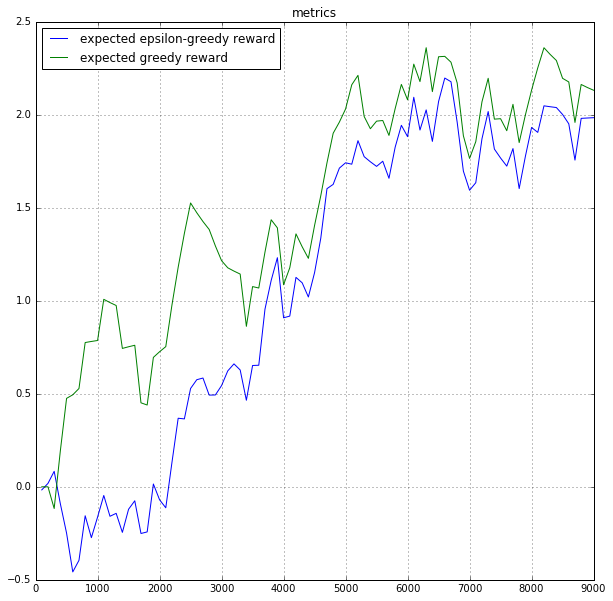

Random session examples
session # 0
 Y2(qv = 2.00248718262) -> 3.0(ref = 3.29454398155) |  X1(qv = 0.310046225786) -> -1.0(ref = -0.95176500082) |  End_session_now(qv = 0.0507736802101) -> 0.0(ref = 0.0281639341265) |  X3(qv = 0.0296462476254) -> 0.0(ref = 0.0) | 



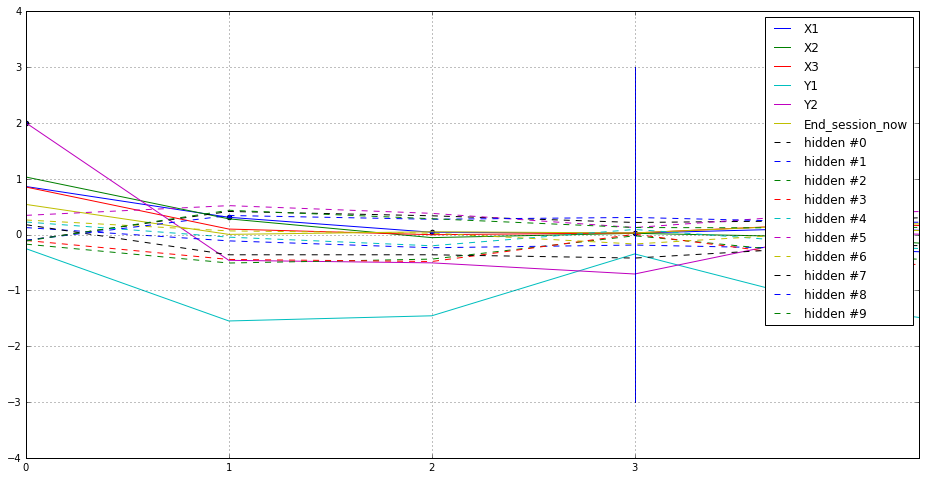

session # 1
 Y2(qv = 2.00248718262) -> 3.0(ref = 3.29454398155) |  X1(qv = 0.310046225786) -> 1.0(ref = 0.971251904964) |  End_session_now(qv = -0.0302611589432) -> 0.0(ref = -0.0179981831461) |  End_session_now(qv = -0.0189454555511) -> 0.0(ref = 0.0) | 



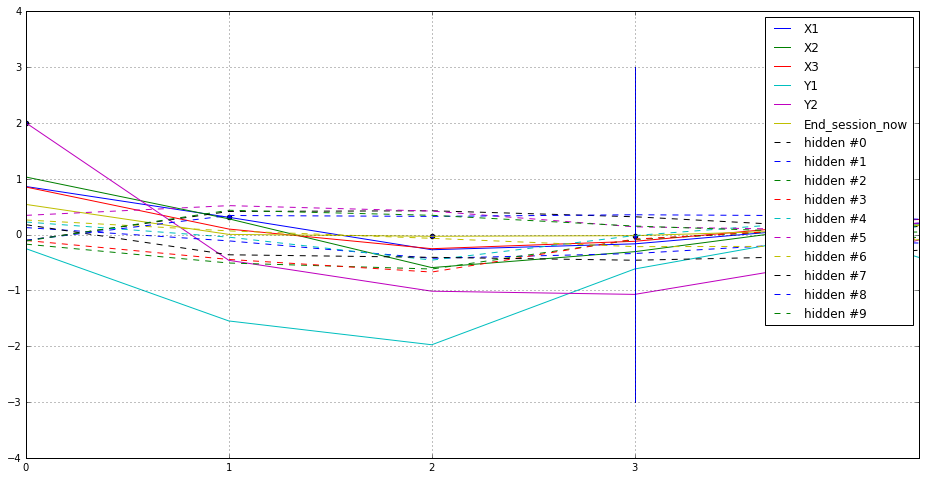

session # 2
 Y2(qv = 2.00248718262) -> 3.0(ref = 3.29454398155) |  X1(qv = 0.310046225786) -> -1.0(ref = -0.95176500082) |  X1(qv = 0.04195484519) -> -0.5(ref = -0.370160728693) |  End_session_now(qv = 0.136672914028) -> 0.0(ref = 0.111284807324) |  X2(qv = 0.117141902447) -> 0.0(ref = 0.0) | 



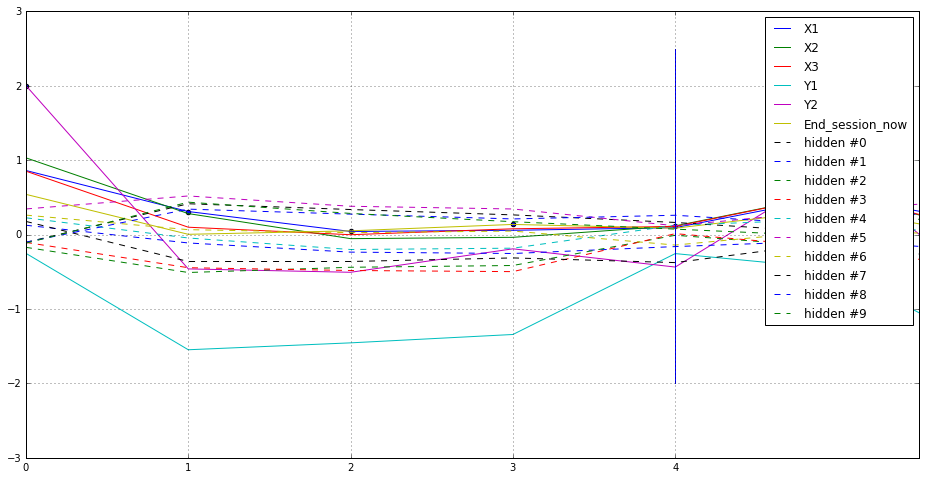

epoch 9100,loss 2.13506, epsilon 0.07494, rewards: ( e-greedy 2.18602, greedy 2.31884) 
rec 2.100 reg 0.035
epoch 9200,loss 2.16134, epsilon 0.07396, rewards: ( e-greedy 2.36741, greedy 2.48696) 
rec 2.126 reg 0.035
epoch 9300,loss 7.51881, epsilon 0.07302, rewards: ( e-greedy 2.33067, greedy 2.43826) 
rec 7.484 reg 0.035
epoch 9400,loss 2.38902, epsilon 0.07212, rewards: ( e-greedy 2.43094, greedy 2.52777) 
rec 2.354 reg 0.035
epoch 9500,loss 7.10580, epsilon 0.07125, rewards: ( e-greedy 2.32118, greedy 2.40832) 
rec 7.070 reg 0.035
epoch 9600,loss 2.37268, epsilon 0.07042, rewards: ( e-greedy 2.42239, greedy 2.50082) 
rec 2.337 reg 0.035
epoch 9700,loss 3.22774, epsilon 0.06962, rewards: ( e-greedy 2.38015, greedy 2.45074) 
rec 3.192 reg 0.035
epoch 9800,loss 2.50610, epsilon 0.06885, rewards: ( e-greedy 2.45881, greedy 2.53900) 
rec 2.471 reg 0.035
epoch 9900,loss 6.80834, epsilon 0.06811, rewards: ( e-greedy 2.41293, greedy 2.48510) 
rec 6.773 reg 0.035
epoch 10000,loss 11.41056, e

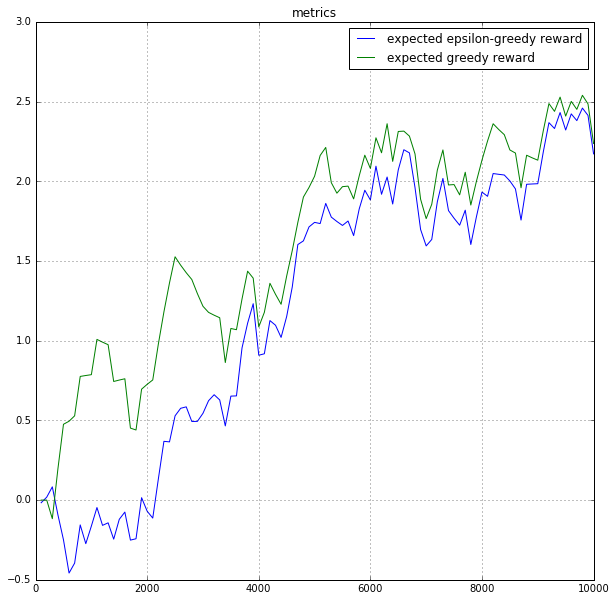

Random session examples
session # 0
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087665319) -> 1.0(ref = 0.97319406271) |  End_session_now(qv = -0.0282167494297) -> 0.0(ref = -0.0169081632048) |  End_session_now(qv = -0.0177980661392) -> 0.0(ref = 0.0) | 



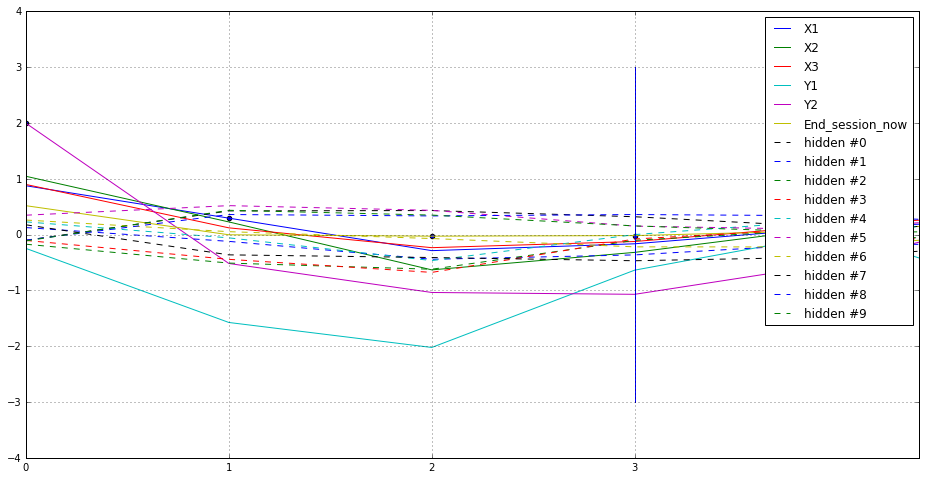

session # 1
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087665319) -> 1.0(ref = 0.97319406271) |  End_session_now(qv = -0.0282167494297) -> 0.0(ref = -0.0169081632048) |  End_session_now(qv = -0.0177980661392) -> 0.0(ref = 0.0) | 



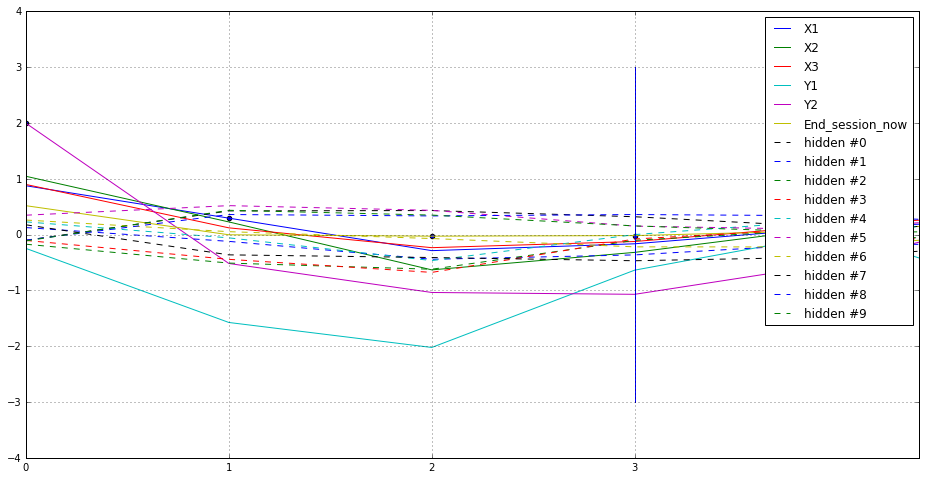

session # 2
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087665319) -> -1.0(ref = -0.958829700947) |  End_session_now(qv = 0.0433371663094) -> 0.0(ref = 0.01768453978) |  End_session_now(qv = 0.0186153054237) -> 0.0(ref = 0.0) | 



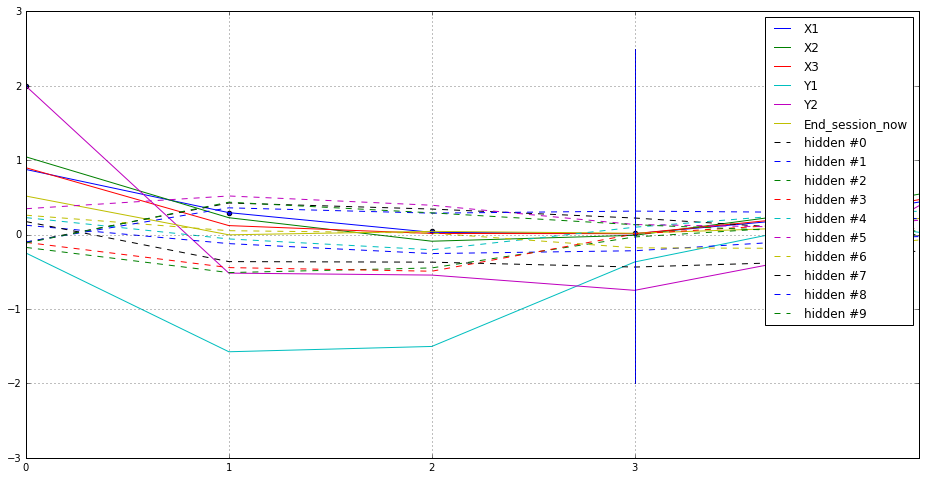

In [25]:
n_epochs = 10000
batch_size=3

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %1000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results
* in this case, a network has obvoiusly not converged, so actions ought to be suboptimal
* running network for longer may yield better results

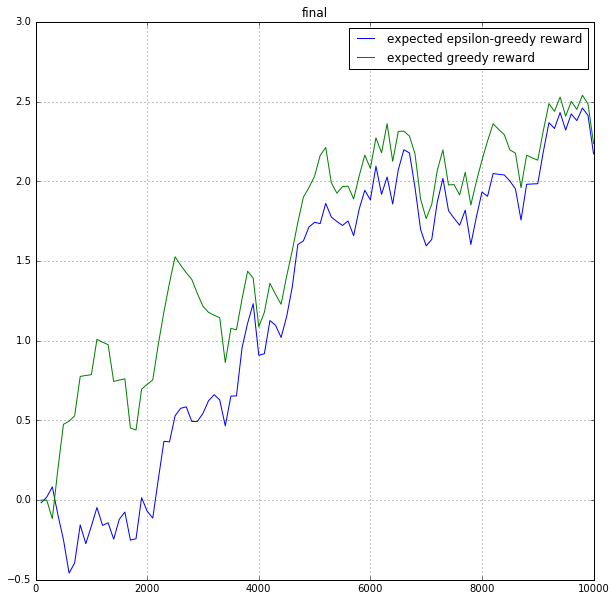

In [26]:
score_log.plot("final")

Random session examples
session # 0
 Y2(qv = 1.9956805706) -> -3.0(ref = -2.00484442711) |  X2(qv = 1.04753220081) -> 1.0(ref = 1.06832146645) |  End_session_now(qv = 0.0719173848629) -> 0.0(ref = 0.0437061749399) |  End_session_now(qv = 0.046006500721) -> 0.0(ref = 0.0) | 



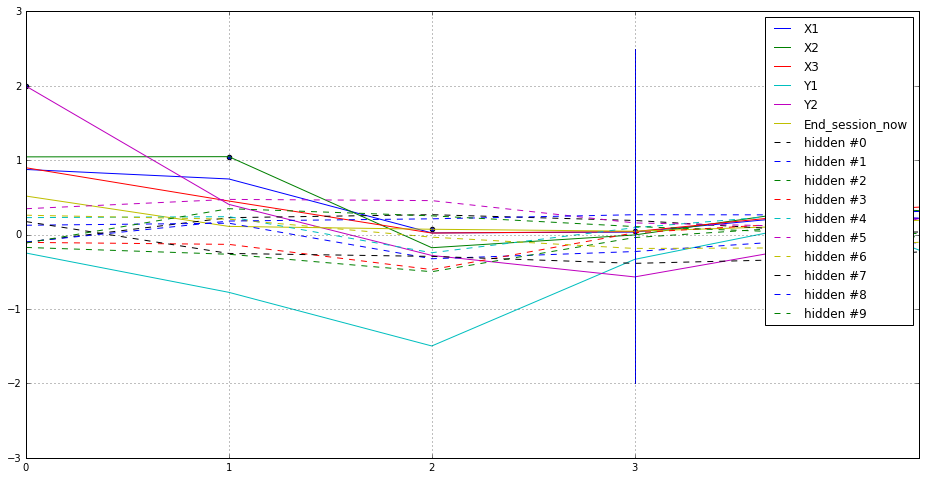

session # 1
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087695122) -> 1.0(ref = 0.97319406271) |  End_session_now(qv = -0.0282167494297) -> 0.0(ref = -0.0169081911445) |  End_session_now(qv = -0.0177980959415) -> 0.0(ref = 0.0) | 



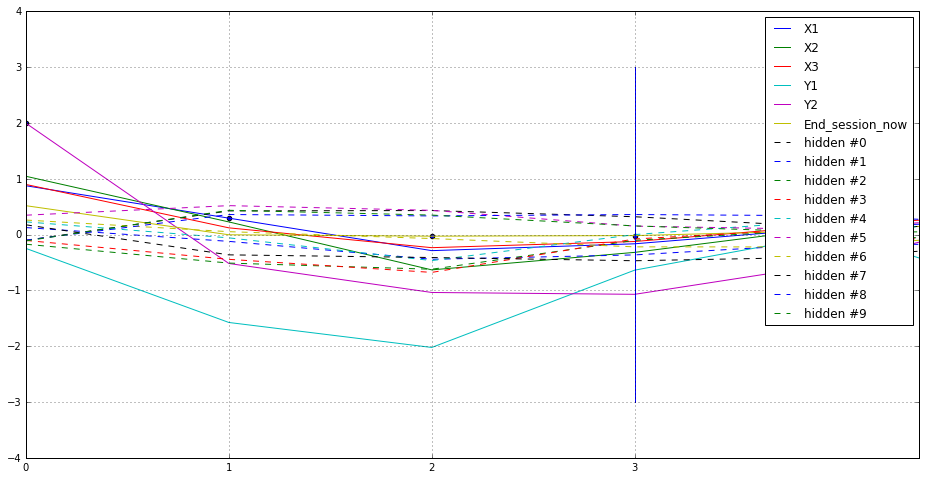

session # 2
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087695122) -> 1.0(ref = 0.97319406271) |  End_session_now(qv = -0.0282167494297) -> 0.0(ref = -0.0169081911445) |  End_session_now(qv = -0.0177980959415) -> 0.0(ref = 0.0) | 



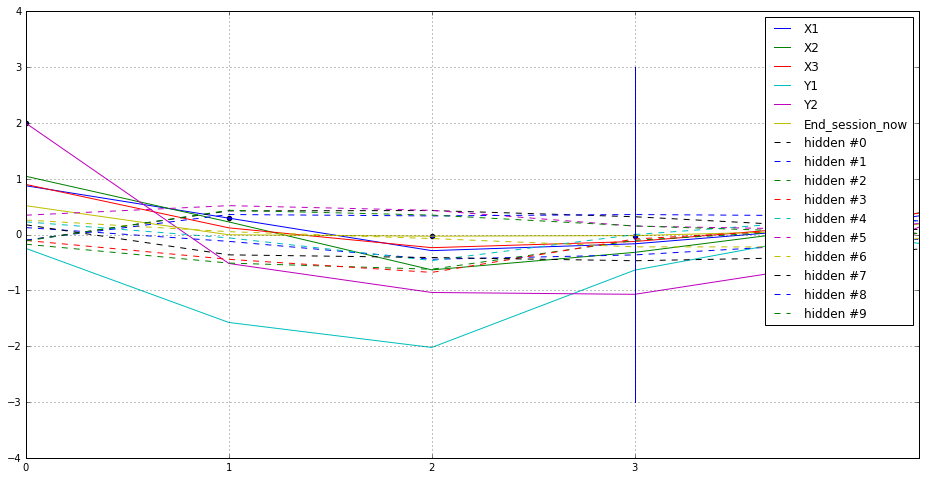

session # 3
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087695122) -> -1.0(ref = -0.958829700947) |  End_session_now(qv = 0.043337136507) -> 0.0(ref = 0.0176845118403) |  End_session_now(qv = 0.0186152756214) -> 0.0(ref = 0.0) | 



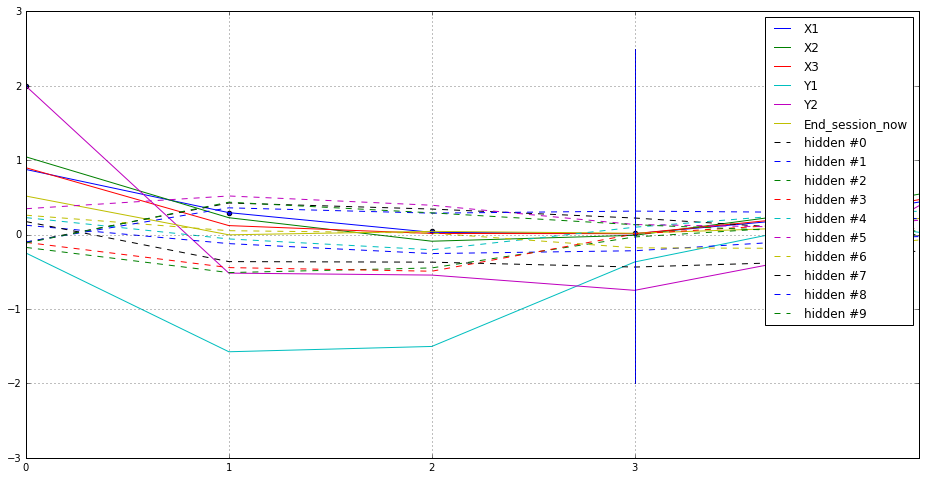

session # 4
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087665319) -> -1.0(ref = -0.958829700947) |  End_session_now(qv = 0.0433371663094) -> 0.0(ref = 0.01768453978) |  End_session_now(qv = 0.0186153054237) -> 0.0(ref = 0.0) | 



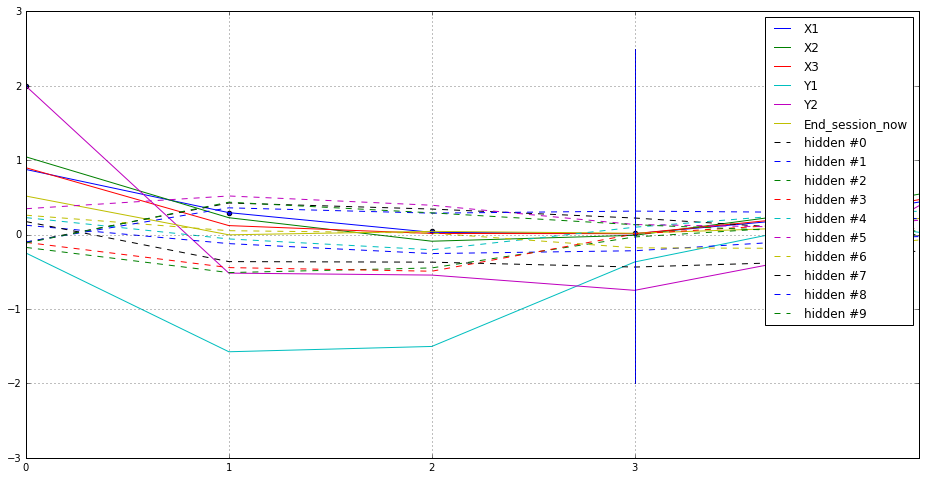

session # 5
 Y2(qv = 1.9956805706) -> -3.0(ref = -2.00484442711) |  X2(qv = 1.04753220081) -> 1.0(ref = 1.06832146645) |  End_session_now(qv = 0.0719173848629) -> 0.0(ref = 0.0437061749399) |  End_session_now(qv = 0.046006500721) -> 0.0(ref = 0.0) | 



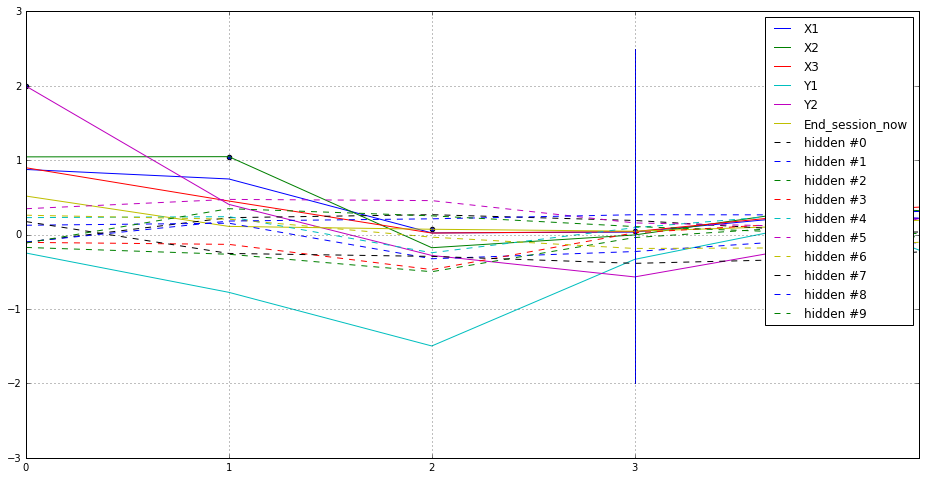

session # 6
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087695122) -> 1.0(ref = 0.97319406271) |  End_session_now(qv = -0.0282167494297) -> 0.0(ref = -0.0169081911445) |  End_session_now(qv = -0.0177980959415) -> 0.0(ref = 0.0) | 



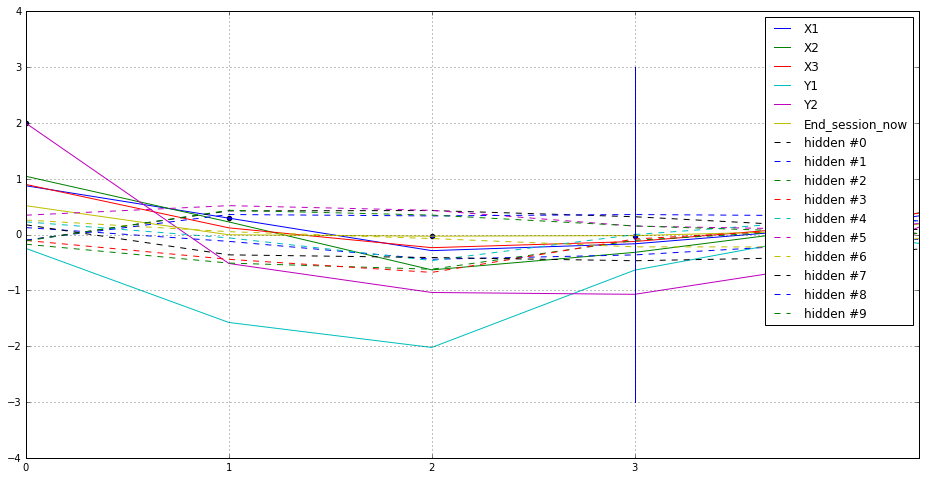

session # 7
 Y2(qv = 1.9956805706) -> -3.0(ref = -2.00484442711) |  X2(qv = 1.04753220081) -> 1.0(ref = 1.06832146645) |  End_session_now(qv = 0.0719173848629) -> 0.0(ref = 0.0437061749399) |  End_session_now(qv = 0.046006500721) -> 0.0(ref = 0.0) | 



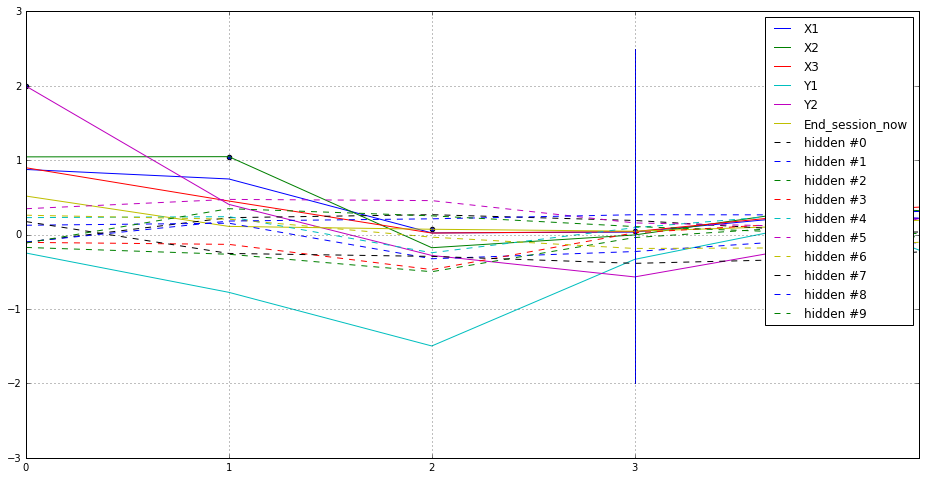

session # 8
 Y2(qv = 1.9956805706) -> -3.0(ref = -2.00484442711) |  X2(qv = 1.04753220081) -> 1.0(ref = 1.06832146645) |  End_session_now(qv = 0.0719173848629) -> 0.0(ref = 0.0437061749399) |  End_session_now(qv = 0.046006500721) -> 0.0(ref = 0.0) | 



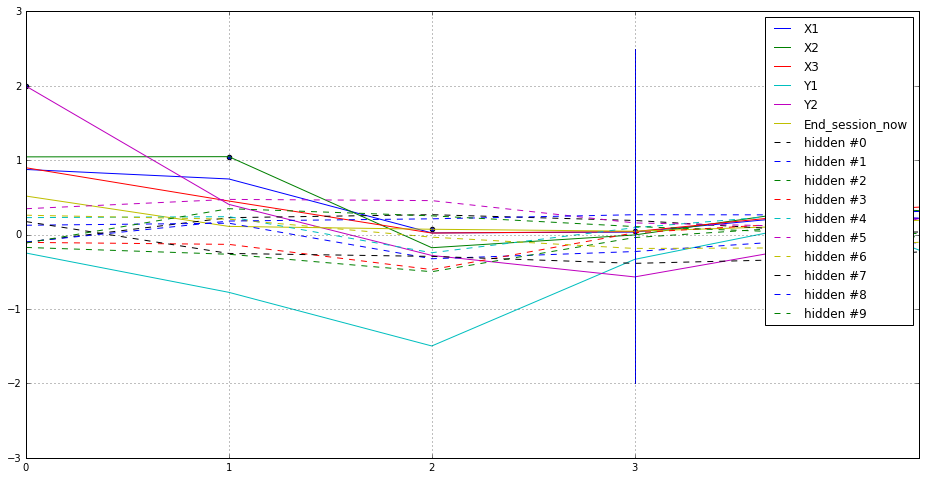

session # 9
 Y2(qv = 1.9956805706) -> 3.0(ref = 3.28033328056) |  X1(qv = 0.295087665319) -> -1.0(ref = -0.958829700947) |  End_session_now(qv = 0.0433371663094) -> 0.0(ref = 0.01768453978) |  End_session_now(qv = 0.0186153054237) -> 0.0(ref = 0.0) | 



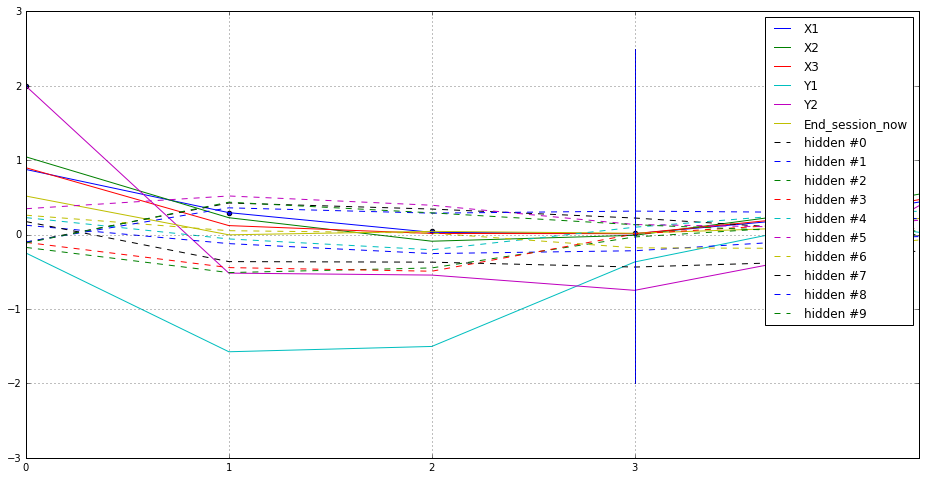

In [27]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
